<a href="https://colab.research.google.com/github/Van-Wu1/cycle/blob/main/scr/py/s2_env_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

Mounted at /content/drive
BoroughShp  GreatLondonShp  s1	s2_Env	s3


In [12]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.strtree import STRtree
import numpy as np
import matplotlib.pyplot as plt

In [13]:
env_gdf = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/s2_Env/Export/edges_gvi_no2_nf.gpkg")
print(env_gdf.columns)

Index(['id', 'name', 'way_type', 'gvi_final', 'gvi_flag', 'gvi_final_norm',
       'gvi_group', 'NO2_mean', 'natural_score', 'geometry'],
      dtype='object')


In [14]:
# 检查是否还有空值
print(env_gdf[['gvi_final', 'NO2_mean']].isna().sum())

gvi_final    528
NO2_mean      83
dtype: int64


In [15]:
# 计算两个字段的均值（排除 NaN）
gvi_mean  = env_gdf['gvi_final'].mean(skipna=True)
no2_mean  = env_gdf['NO2_mean'].mean(skipna=True)

print(f"GVI 均值: {gvi_mean:.4f}")
print(f"NO₂ 均值: {no2_mean:.4f}")

# 用均值补全缺失值
env_gdf['gvi_final'] = env_gdf['gvi_final'].fillna(gvi_mean)
env_gdf['NO2_mean']  = env_gdf['NO2_mean'].fillna(no2_mean)

GVI 均值: 13.9626
NO₂ 均值: 22.3973


In [16]:
# 检查是否还有空值
print(env_gdf[['gvi_final', 'NO2_mean']].isna().sum())

gvi_final    0
NO2_mean     0
dtype: int64


In [17]:
# ===== 参数 =====
P_LOW, P_HIGH = 1, 99          # 稳健裁剪分位
W_GVI, W_NO2, W_NAT = 0.5, 0.3, 0.2   # 环境维度权重
IN_PATH = None
OUT_PATH = "/content/drive/MyDrive/CASA0004_Cycling/data/s2_Env/Export/index_s2.gpkg"
LAYER_OUT = "index_s2"

In [18]:
# --------- 工具函数 ----------
def minmax(series: pd.Series):
    s = pd.to_numeric(series, errors="coerce")
    vmin = np.nanmin(s) if np.isfinite(np.nanmin(s)) else np.nan
    vmax = np.nanmax(s) if np.isfinite(np.nanmax(s)) else np.nan
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax == vmin:
        return pd.Series(np.zeros(len(s)), index=s.index)
    out = (s - vmin) / (vmax - vmin)
    return out.fillna(0)

In [19]:
def robust_minmax(series: pd.Series, p_low=1, p_high=99):
    """分位裁剪 + MinMax 归一化到[0,1]；NaN→0"""
    s = pd.to_numeric(series, errors="coerce")
    if s.notna().sum() == 0:
        return pd.Series(np.zeros(len(s)), index=s.index)
    lo, hi = np.nanpercentile(s.dropna(), [p_low, p_high])
    s_clip = s.clip(lower=lo, upper=hi)
    vmin, vmax = np.nanmin(s_clip), np.nanmax(s_clip)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmax == vmin:
        return pd.Series(np.zeros(len(s)), index=s.index)
    return ((s_clip - vmin) / (vmax - vmin)).fillna(0)

In [20]:
if IN_PATH:
    env_gdf = gpd.read_file(IN_PATH)

In [21]:
# ---- 健壮性检查 ----
need_cols = ["gvi_final", "NO2_mean", "natural_score"]
missing = [c for c in need_cols if c not in env_gdf.columns]
if missing:
    raise ValueError(f"缺少必要字段: {missing}")

# 正向指标：GVI
env_gdf["fac_gvi"]   = robust_minmax(env_gdf["gvi_final"], P_LOW, P_HIGH)

# 反向指标：NO2
no2_norm = robust_minmax(env_gdf["NO2_mean"], P_LOW, P_HIGH)
env_gdf["fac_no2"] = 1 - no2_norm

# rename
env_gdf["fac_nat"] = env_gdf["natural_score"]

# 合成
den = (W_GVI + W_NO2 + W_NAT)
env_gdf["index_2"] = (W_GVI * env_gdf["fac_gvi"]
                 + W_NO2 * env_gdf["fac_no2"]
                 + W_NAT * env_gdf["fac_nat"]) / den


In [22]:
print(env_gdf.columns)

Index(['id', 'name', 'way_type', 'gvi_final', 'gvi_flag', 'gvi_final_norm',
       'gvi_group', 'NO2_mean', 'natural_score', 'geometry', 'fac_gvi',
       'fac_no2', 'fac_nat', 'index_2'],
      dtype='object')


In [23]:
# 4) 导出（保留关键列）
keep_cols = [
    "id","name","way_type",
    "gvi_final","fac_gvi",
    "NO2_mean","fac_no2",
    "natural_score","fac_nat",
    "index_2","geometry"
]
out_gdf = env_gdf[keep_cols].copy()
out_gdf.to_file(OUT_PATH, layer=LAYER_OUT, driver="GPKG")
print(f"导出 {OUT_PATH} (layer='{LAYER_OUT}')")

导出 /content/drive/MyDrive/CASA0004_Cycling/data/s2_Env/Export/index_s2.gpkg (layer='index_s2')


# 以下为附加代码

环境指数描述统计：
count    164076.000000
mean          0.462853
std           0.148099
min           0.000000
25%           0.366784
50%           0.455518
75%           0.558199
max           1.000000
Name: index_2, dtype: float64


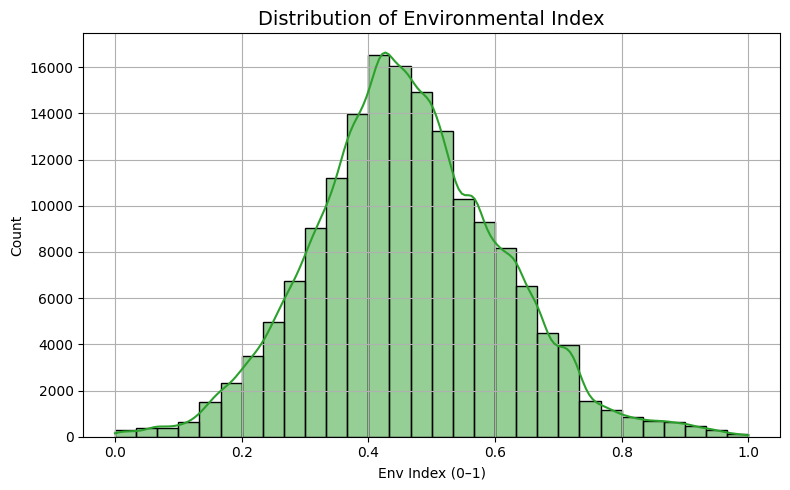

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. 描述性统计 ===
print("环境指数描述统计：")
print(env_gdf['index_2'].describe())

# === 2. 分布直方图 ===
plt.figure(figsize=(8, 5))
sns.histplot(env_gdf['index_2'], bins=30, kde=True, color="#2ca02c")
plt.title("Distribution of Environmental Index", fontsize=14)
plt.xlabel("Env Index (0–1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

GVI描述统计：
count    164076.000000
mean          0.354940
std           0.179850
min           0.000000
25%           0.273974
50%           0.357314
75%           0.424574
max           1.000000
Name: fac_gvi, dtype: float64


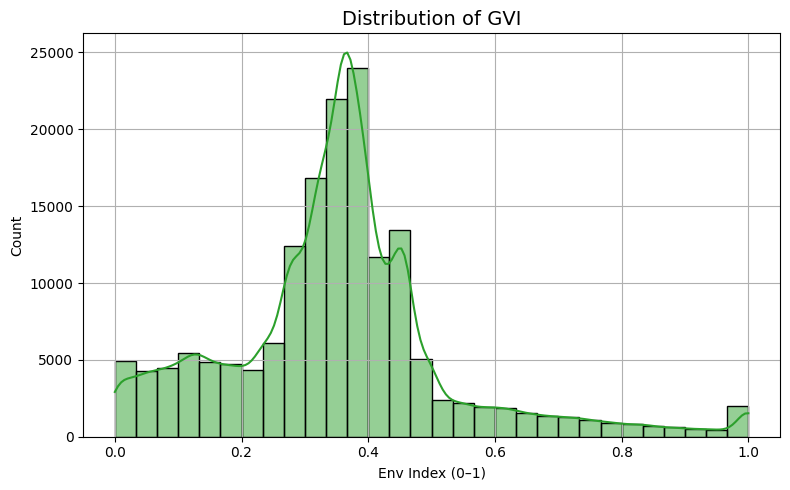

In [27]:
# === 1. 描述性统计 ===
print("GVI描述统计：")
print(env_gdf['fac_gvi'].describe())

# === 2. 分布直方图 ===
plt.figure(figsize=(8, 5))
sns.histplot(env_gdf['fac_gvi'], bins=30, kde=True, color="#2ca02c")
plt.title("Distribution of GVI", fontsize=14)
plt.xlabel("Env Index (0–1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

环境指数描述统计：
count    164076.000000
mean          0.724839
std           0.186906
min           0.000000
25%           0.634628
50%           0.765981
75%           0.856529
max           1.000000
Name: fac_no2, dtype: float64


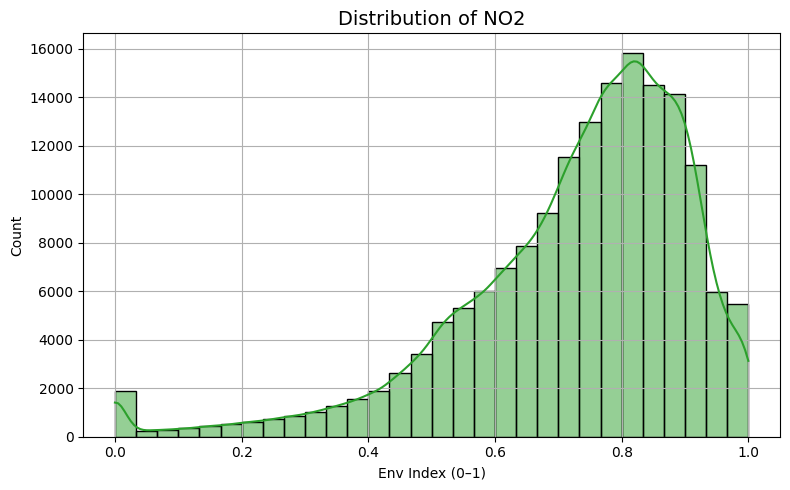

In [28]:
# === 1. 描述性统计 ===
print("环境指数描述统计：")
print(env_gdf['fac_no2'].describe())

# === 2. 分布直方图 ===
plt.figure(figsize=(8, 5))
sns.histplot(env_gdf['fac_no2'], bins=30, kde=True, color="#2ca02c")
plt.title("Distribution of NO2", fontsize=14)
plt.xlabel("Env Index (0–1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

环境指数描述统计：
count    164076.000000
mean          0.339657
std           0.359174
min           0.000000
25%           0.000000
50%           0.200000
75%           0.700000
max           1.000000
Name: fac_nat, dtype: float64


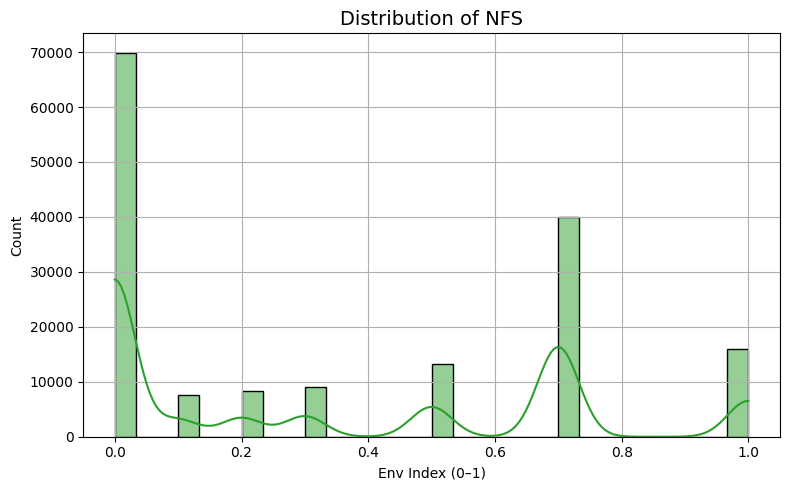

In [29]:
# === 1. 描述性统计 ===
print("环境指数描述统计：")
print(env_gdf['fac_nat'].describe())

# === 2. 分布直方图 ===
plt.figure(figsize=(8, 5))
sns.histplot(env_gdf['fac_nat'], bins=30, kde=True, color="#2ca02c")
plt.title("Distribution of NFS", fontsize=14)
plt.xlabel("Env Index (0–1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()